In [2]:
import glob
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [192]:
class dataset:

    def _get_dir_list(self, path):
        return glob.glob(path)

    def _get_file_list_in_dir(self, d):
        f = glob.glob(d + '/*.csv')
        f.sort()
        return f

    def _get_df_from_csv(self, f):
        is_iOS = "iphone" in f
        df = pd.read_csv(f)

        if is_iOS:
            # rename column name to integrate
            df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
            # remove unsaved parameters
            del df['magneticField.accuracy']
            del df['magneticField.field.x']
            del df['magneticField.field.y']
            del df['magneticField.field.z']
        else:
            # rename column name to integrate
            df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
            df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
            # remove unsaved parameters
            del df['temperature']
            del df['humidity']
            del df['proximity']

        # remove data while rssi is not recorded
        buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
        if len(buf) == 0:
            print('x', end='')
            return None
        first_rssi_idx = buf[0]
        df = df.ix[first_rssi_idx:, :]

        # adjust the value of button pushed data 
        df.loc[df['btn_push'] == -1, 'btn_push'] = 0

        # convert -1 to NaN
        df[df == -1] = np.nan

        # interpolate NaN
        df = df.apply(pd.Series.interpolate)

        print('.', end='')

        return df

    def __init__(self, path='data/raw/*_*_0[1-4]*'):
        self.path = path
        d = self._get_dir_list(path)
        title = [os.path.basename(_d) for _d in d]

        r = []
        for _d in d[:2]:
            print(_d)
            title = os.path.basename(_d)
            file_list = self._get_file_list_in_dir(_d)
            fname_list = [os.path.basename(_f) for _f in file_list]
            df_list = [self._get_df_from_csv(f) for f in file_list]
            print('')
            r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

        self.df_master = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
    
    def _time_range_around_button_push(self, df, before=0, after=0):
        t = df[df['btn_push'] == 1].index
        point = t[0] if len(t) > 0 else df.index[-1] - 150
        return df.loc[(point - before):(point + after)]

    def get_data(self, title='.*', fname='.*', before=None, after=0, column=None):
        # extract the [title, fname, dataframe]
        dfm = self.df_master[self.df_master['title'].str.contains(title)]
        dfm = dfm[dfm['fname'].str.contains(fname)]
        # to list of dataframe
        dfml = [d for d in dfm['dataframe'].tolist() if d is not None]
        # limit the time range
        dfml = [self._time_range_around_button_push(d, before, after) for d in dfml]
        # limit the column
        if column != None: dfml = [d[column] for d in dfml]
        print("extracted %d dataframes" % (len(dfml)))
        return dfml

In [193]:
ds = dataset()
ds.df_master[ds.df_master['title'] == '01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅']['dataframe'][0].head()

data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/02_03_03_4F実験室_iphone_カバン_裏上_異常_まっすぐ帰宅
..............................


,date,rssi.a,rssi.b,remote_rssi,linear_accel[0],linear_accel[1],linear_accel[2],accelerometer[0],accelerometer[1],accelerometer[2],...,game_rotation[0],game_rotation[1],game_rotation[2],game_rotation[3],magnetic[0],magnetic[1],magnetic[2],pressure,light,btn_push
91,2017/04/06 14:22:23.334,-62.000000,-62.000000,-81.0,0.107452,0.013687,-0.266391,0.587601,2.197723,9.080734,...,0.096745,0.062251,0.681178,0.723023,18.890984,3.055763,-18.236160,NaN,NaN,0.0
92,2017/04/06 14:22:23.354,-66.333333,-63.428571,-81.0,0.149785,0.028881,-0.196661,0.700928,2.234436,9.088989,...,0.096946,0.062199,0.681327,0.722859,18.890984,3.055763,-18.324090,1017.940550,NaN,0.0
93,2017/04/06 14:22:23.376,-70.666667,-64.857143,-81.0,0.192119,0.044076,-0.126932,0.554733,2.217590,9.249832,...,0.097190,0.061880,0.681452,0.722737,18.709404,3.328323,-18.412018,1017.945525,NaN,0.0
94,2017/04/06 14:22:23.395,-75.000000,-66.285714,-72.0,-0.086707,0.132139,0.141152,0.397614,2.316269,9.463730,...,0.097190,0.061788,0.681132,0.723046,18.709404,3.419304,-18.587875,1017.950500,110.0,0.0
95,2017/04/06 14:22:23.415,-70.500000,-67.714286,-72.0,-0.023780,0.118709,0.021171,0.336319,2.278671,9.353012,...,0.097196,0.062068,0.681002,0.723144,18.709404,3.328514,-18.412018,1017.950500,109.5,0.0


In [178]:
ds.df_master[ds.df_master['title'].str.contains('02_03_03_4F実験室_iphone_カバン_裏上_異常_まっすぐ帰宅')]['fname'][30]

'20170331170742_ik01.csv'

In [179]:
ds.df_master[ds.df_master['title'].str.contains('02_03_03_4F実験室_iphone_カバン_裏上_異常_まっすぐ帰宅')]['dataframe'][30]

,date,rssi.a,rssi.b,remote_rssi,acceleration.x,acceleration.y,acceleration.z,gyro.rotationRate.x,gyro.rotationRate.y,gyro.rotationRate.z,...,rotationRate.x,rotationRate.y,rotationRate.z,gravity.x,gravity.y,gravity.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,btn_push
50,2017/03/31 17:07:28.573,-55.000000,-55.000000,NaN,0.087448,-0.282623,-0.948288,-0.785466,0.097337,-0.664371,...,-0.690743,0.120738,-0.664062,0.117518,-0.276964,-0.953667,-0.026240,0.006487,-0.002815,0.0
51,2017/03/31 17:07:28.585,-60.000000,-60.333333,NaN,0.104919,-0.286987,-0.997864,-0.786298,0.178539,-0.586792,...,-0.691576,0.201940,-0.586483,0.120921,-0.269641,-0.955339,-0.033472,-0.012982,0.007051,0.0
52,2017/03/31 17:07:28.605,-65.500000,-65.666667,NaN,0.036148,-0.273376,-1.187225,-1.048291,-0.541985,-0.255713,...,-0.953570,-0.518584,-0.255404,0.121325,-0.253388,-0.959726,-0.043978,0.002060,-0.145895,0.0
53,2017/03/31 17:07:28.625,-71.000000,-71.000000,NaN,0.021042,-0.310684,-1.060730,-1.681218,-2.444563,0.106741,...,-1.586497,-2.421162,0.107050,0.087599,-0.227098,-0.969924,-0.066557,-0.083586,-0.090806,0.0
54,2017/03/31 17:07:28.645,-67.333333,-69.000000,NaN,0.084137,-0.147461,-0.922791,-1.807991,-3.282390,0.252245,...,-1.622546,-2.889359,0.231969,0.012587,-0.185895,-0.982489,0.071550,0.038434,0.059698,0.0
55,2017/03/31 17:07:28.665,-63.666667,-64.500000,NaN,-0.018906,-0.199585,-0.819778,-0.364274,-0.350148,0.107921,...,-0.269556,-0.326744,0.108229,-0.001990,-0.174049,-0.984735,-0.016915,-0.025536,0.164956,0.0
56,2017/03/31 17:07:28.685,-60.000000,-60.000000,NaN,-0.026947,-0.141602,-1.062592,0.509577,0.725474,-0.227275,...,0.604295,0.748878,-0.226967,0.004850,-0.181979,-0.983290,-0.031797,0.040377,-0.079301,0.0
57,2017/03/31 17:07:28.705,-69.000000,-61.666667,NaN,0.072571,-0.218277,-1.155197,0.349759,0.374161,-0.208246,...,0.296435,0.195210,-0.162970,0.019535,-0.194648,-0.980679,-0.003773,-0.033426,-0.179172,0.0
58,2017/03/31 17:07:28.726,-67.000000,-63.333333,NaN,0.111359,-0.164917,-0.993317,-0.164259,-0.226390,-0.096366,...,-0.120992,-0.229281,-0.074331,0.016259,-0.193914,-0.980884,0.095099,0.028997,-0.012433,0.0
59,2017/03/31 17:07:28.745,-65.000000,-65.000000,NaN,0.056992,-0.171127,-0.962234,-0.126435,-0.170998,-0.049619,...,-0.031063,-0.147012,-0.049462,0.014709,-0.193316,-0.981026,0.042283,0.022189,0.018792,0.0


In [182]:
ds.get_data('.*_4F実験室_Xperia.*_カバン_裏上_.*_まっすぐ帰宅', before=6, after=2, column=['rssi.b','rssi.a','linear_accel[0]','btn_push'])[3]

extracted 29


,rssi.b,rssi.a,linear_accel[0],btn_push
725,-46.0,-38.5,0.168695,0.0
726,-46.0,-39.0,0.044481,0.0
727,-46.0,-38.0,-0.019578,0.0
728,-46.5,-37.0,0.024611,0.0
729,-47.0,-38.5,0.240935,0.0
730,-47.0,-40.0,0.361101,0.0
731,-47.0,-40.0,0.674062,1.0
732,-46.5,-40.0,0.778846,0.0
733,-46.0,-37.5,0.910254,0.0


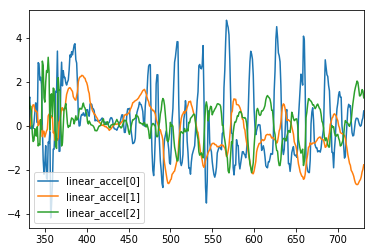

In [160]:
df = ds.get_data(title='.*_4F実験室_X.*_カバン_裏上_.*_まっすぐ帰宅', before=400, after=0, column=['linear_accel[0]','linear_accel[1]','linear_accel[2]'])[3]
df.plot()